# 05 Downstream Preprocessing


In [1]:
from libraries import *
from parameters import *

In [2]:
%load_ext rpy2.ipython

In [3]:
os.getcwd()
os.chdir(projectDir)

In [4]:
adata = sc.read("outputs/anndata/adata-hash-features_singlets_05232020.h5ad")

In [5]:
adata.X.shape

(519535, 13811)

In [6]:
adata.X

<519535x13811 sparse matrix of type '<class 'numpy.float32'>'
	with 963518255 stored elements in Compressed Sparse Row format>

## Normalization and log transform

In [7]:
adata.layers['counts'] = adata.X.copy()

sc.pp.normalize_total(adata, target_sum=par_preprocessing_target_sum)
sc.pp.log1p(adata)
adata.raw = adata

normalizing counts per cell
    finished (0:00:04)


In [8]:
sc.pp.highly_variable_genes(adata, n_top_genes=par_downstream_n_top_genes)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:22)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [9]:
sc.pp.scale(adata, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [10]:
n_pcs = min(min(adata.n_obs, adata.n_vars)-1, par_downstream_n_pcs)
n_pcs

50

In [11]:
sc.pp.pca(adata, n_comps=n_pcs, svd_solver='arpack')

computing PCA
    on highly variable genes


/home/beraslan/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


    with n_comps=50
    finished (0:01:10)


In [12]:
sc.pp.neighbors(adata, n_neighbors=par_downstream_n_neighbors, metric=par_downstream_neighbor_metric)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:14:01)


In [13]:
sc.tl.umap(adata,)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:09:29)


In [14]:
sc.tl.leiden(adata, resolution=0.5)

running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (3:57:05)


In [15]:
sc.tl.diffmap(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:01)
    eigenvalues of transition matrix
    [1.         0.99863887 0.99714994 0.99416834 0.9868315  0.98597395
     0.98219544 0.97915286 0.9763065  0.97542    0.97352034 0.97208774
     0.9704054  0.9688214  0.9678682 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:38)


In [16]:
sc.tl.rank_genes_groups(adata, groupby="leiden", n_genes=2000, method="t-test_overestim_var")

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:00)


In [17]:
umap_point_size = np.maximum(120000/adata.n_obs, 2)

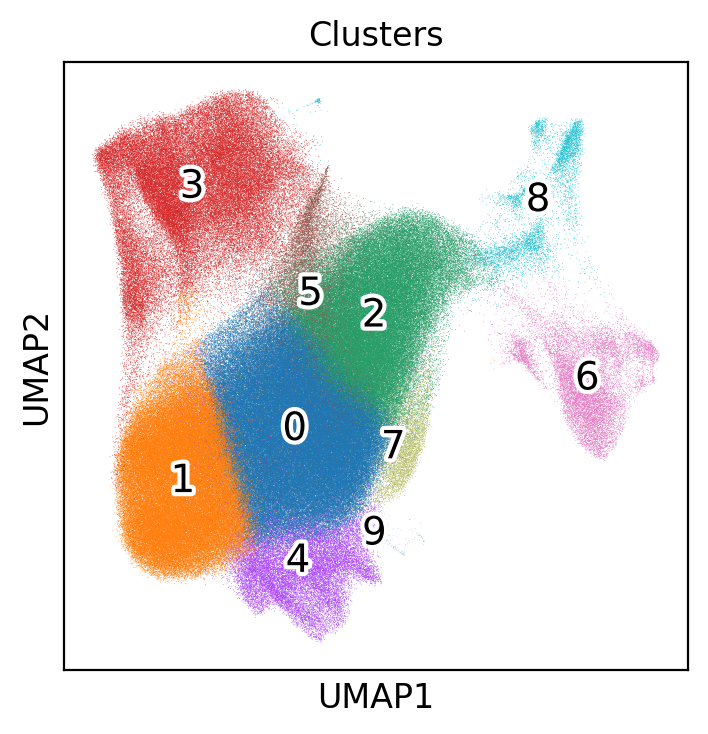

In [18]:
f, ax = plt.subplots(figsize=(4, 4))
sc.pl.umap(adata, color='leiden', legend_loc='on data', legend_fontoutline=3, legend_fontsize=14, legend_fontweight='normal', title='Clusters', ax=ax, show=False, size=0.3);

In [19]:
sc.tl.dendrogram(adata, groupby='leiden')

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns["dendrogram_['leiden']"]`


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


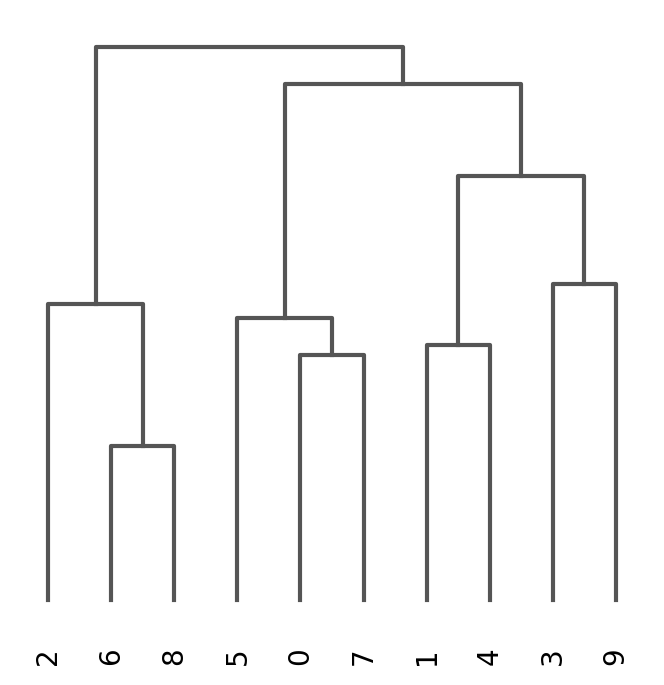

In [20]:
sc.pl.dendrogram(adata, groupby='leiden')

In [21]:
pd.DataFrame(adata.uns['rank_genes_groups']['names'])

0        1       2         3        4       5           6  \
0         Ctsl    Chil3    Mgl2     Stmn1   Sqstm1   Ifit1       Ccl22   
1         Ctsb     Car4    Cd74     Pclaf      Esd   Rsad2        Ccr7   
2        Mmp12    Fabp4   Ccl17     Top2a      Npy   Isg15        Cst3   
3         Ctss    Fabp5    Cd52     Hmgb2    Gpnmb   Slfn5       Fscn1   
4         Lyz2      Cd9   Crip1     Mki67    H2-D1  Ifi204        Ccl5   
...        ...      ...     ...       ...      ...     ...         ...   
1995  Map1lc3a     Ambp  Txnl4a    Mfap1a   Mthfd2     Cd2      Map6d1   
1996      Prr3     Dpp3  Unc13d  Mapkapk2    Atp9b   Cd247      Zfp472   
1997     Gsta3     Sat2  Gtf2h5    Mrpl17  Tmem158   Il23r  AC113595.1   
1998     Trim3   Acaa1b   Nr2f6    Lrrc8b  Slc38a7   Pdia3       Hyal1   
1999     Tigd2  Mettl22   Endog     Ift80   Utp14a    Ddx5    Ppp1r16a   

            7        8       9  
0       Cbln1   H2-Eb1    Lcn2  
1      Gm2694   H2-Ab1  S100a8  
2       Mmp12     Cst3  S100a9  
3      Clec4n    H2-Aa   Ly6c2  
4         Lpl     Cd74  Gm5483  
...       ...      ...     ...  
1995   Gm6710  Olfr433  Nup107  
1996   Ythdf3     Eml3   Rpp14  
1997  Gm14296    Mrps5    Hic2  
1998     Sat1    Derl3   Ubl4a  
1999   Rabep1    Usp22   Ddx3x  

[2000 rows x 10 columns]

In [22]:
markerGenes = pd.DataFrame(adata.uns['rank_genes_groups']['names'])

In [23]:
markerGenes = markerGenes.iloc[0:10,:]

In [24]:
markerGenes = np.unique(markerGenes.values.flatten())

/home/beraslan/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


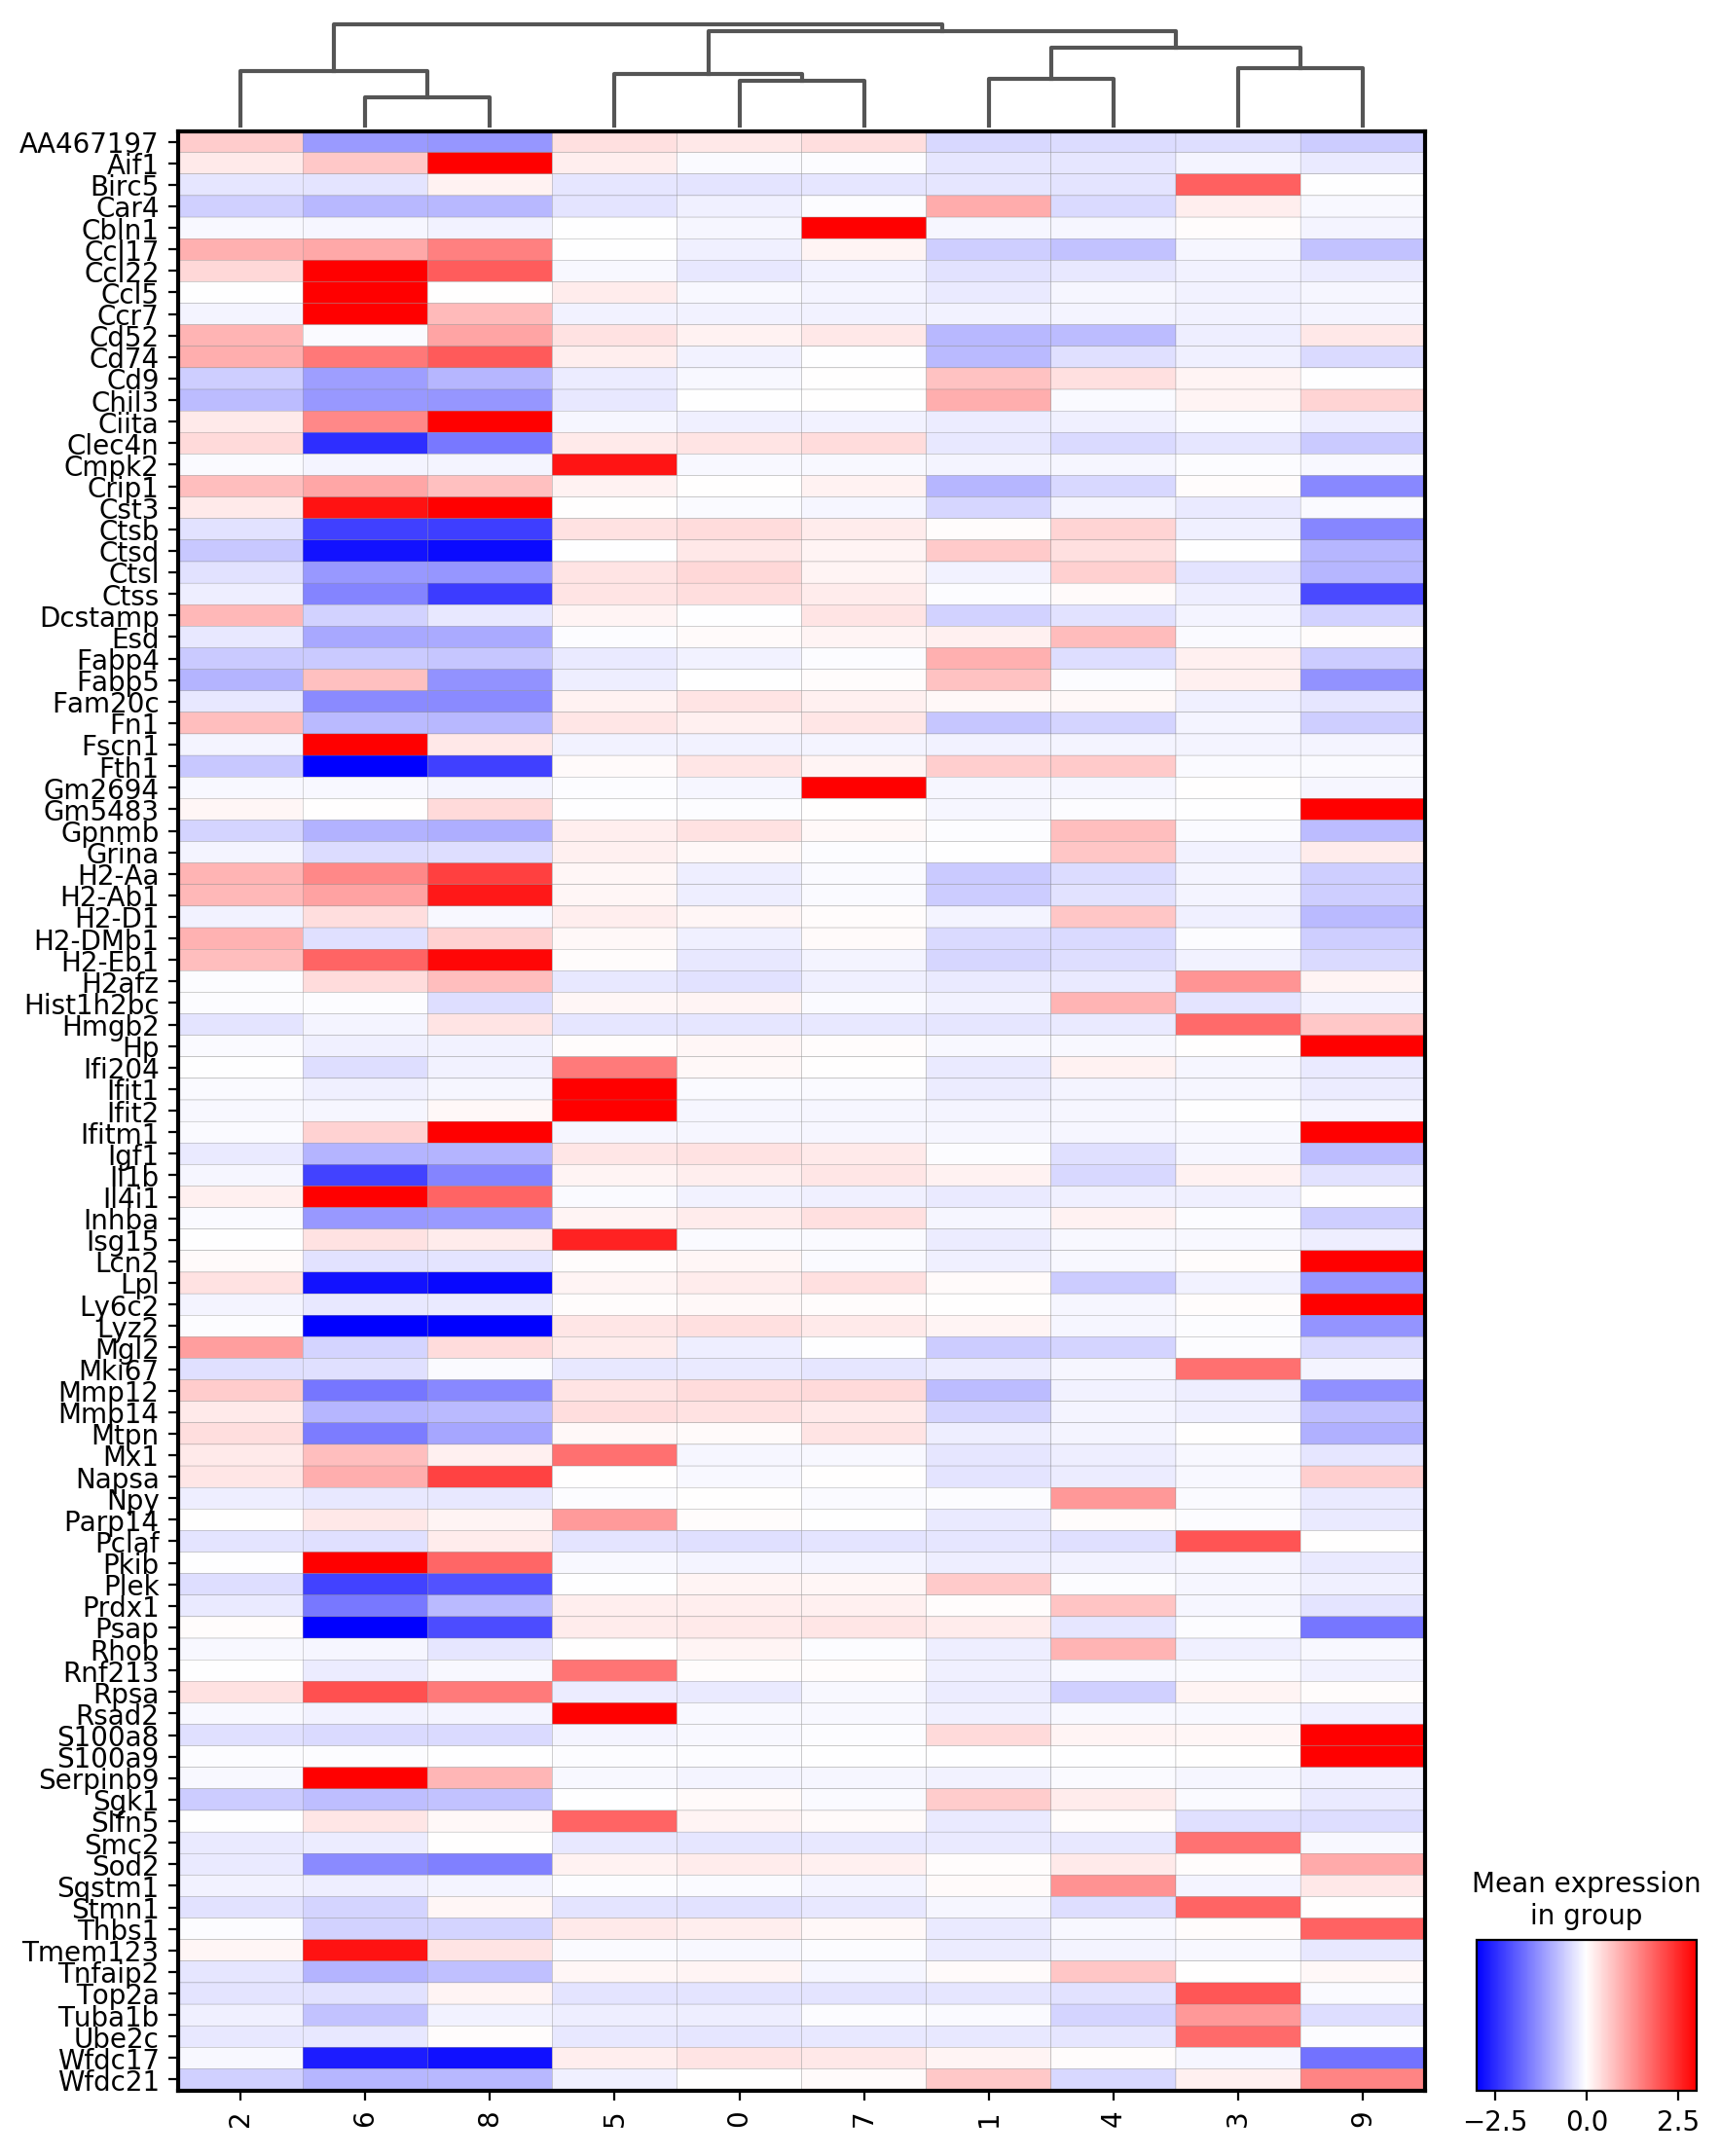

In [25]:
sc.pl.matrixplot(adata, markerGenes, groupby='leiden', dendrogram=True,
                      use_raw=False, vmin=-3, vmax=3,cmap='bwr',  swap_axes=True, figsize=(10,14))

/home/beraslan/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


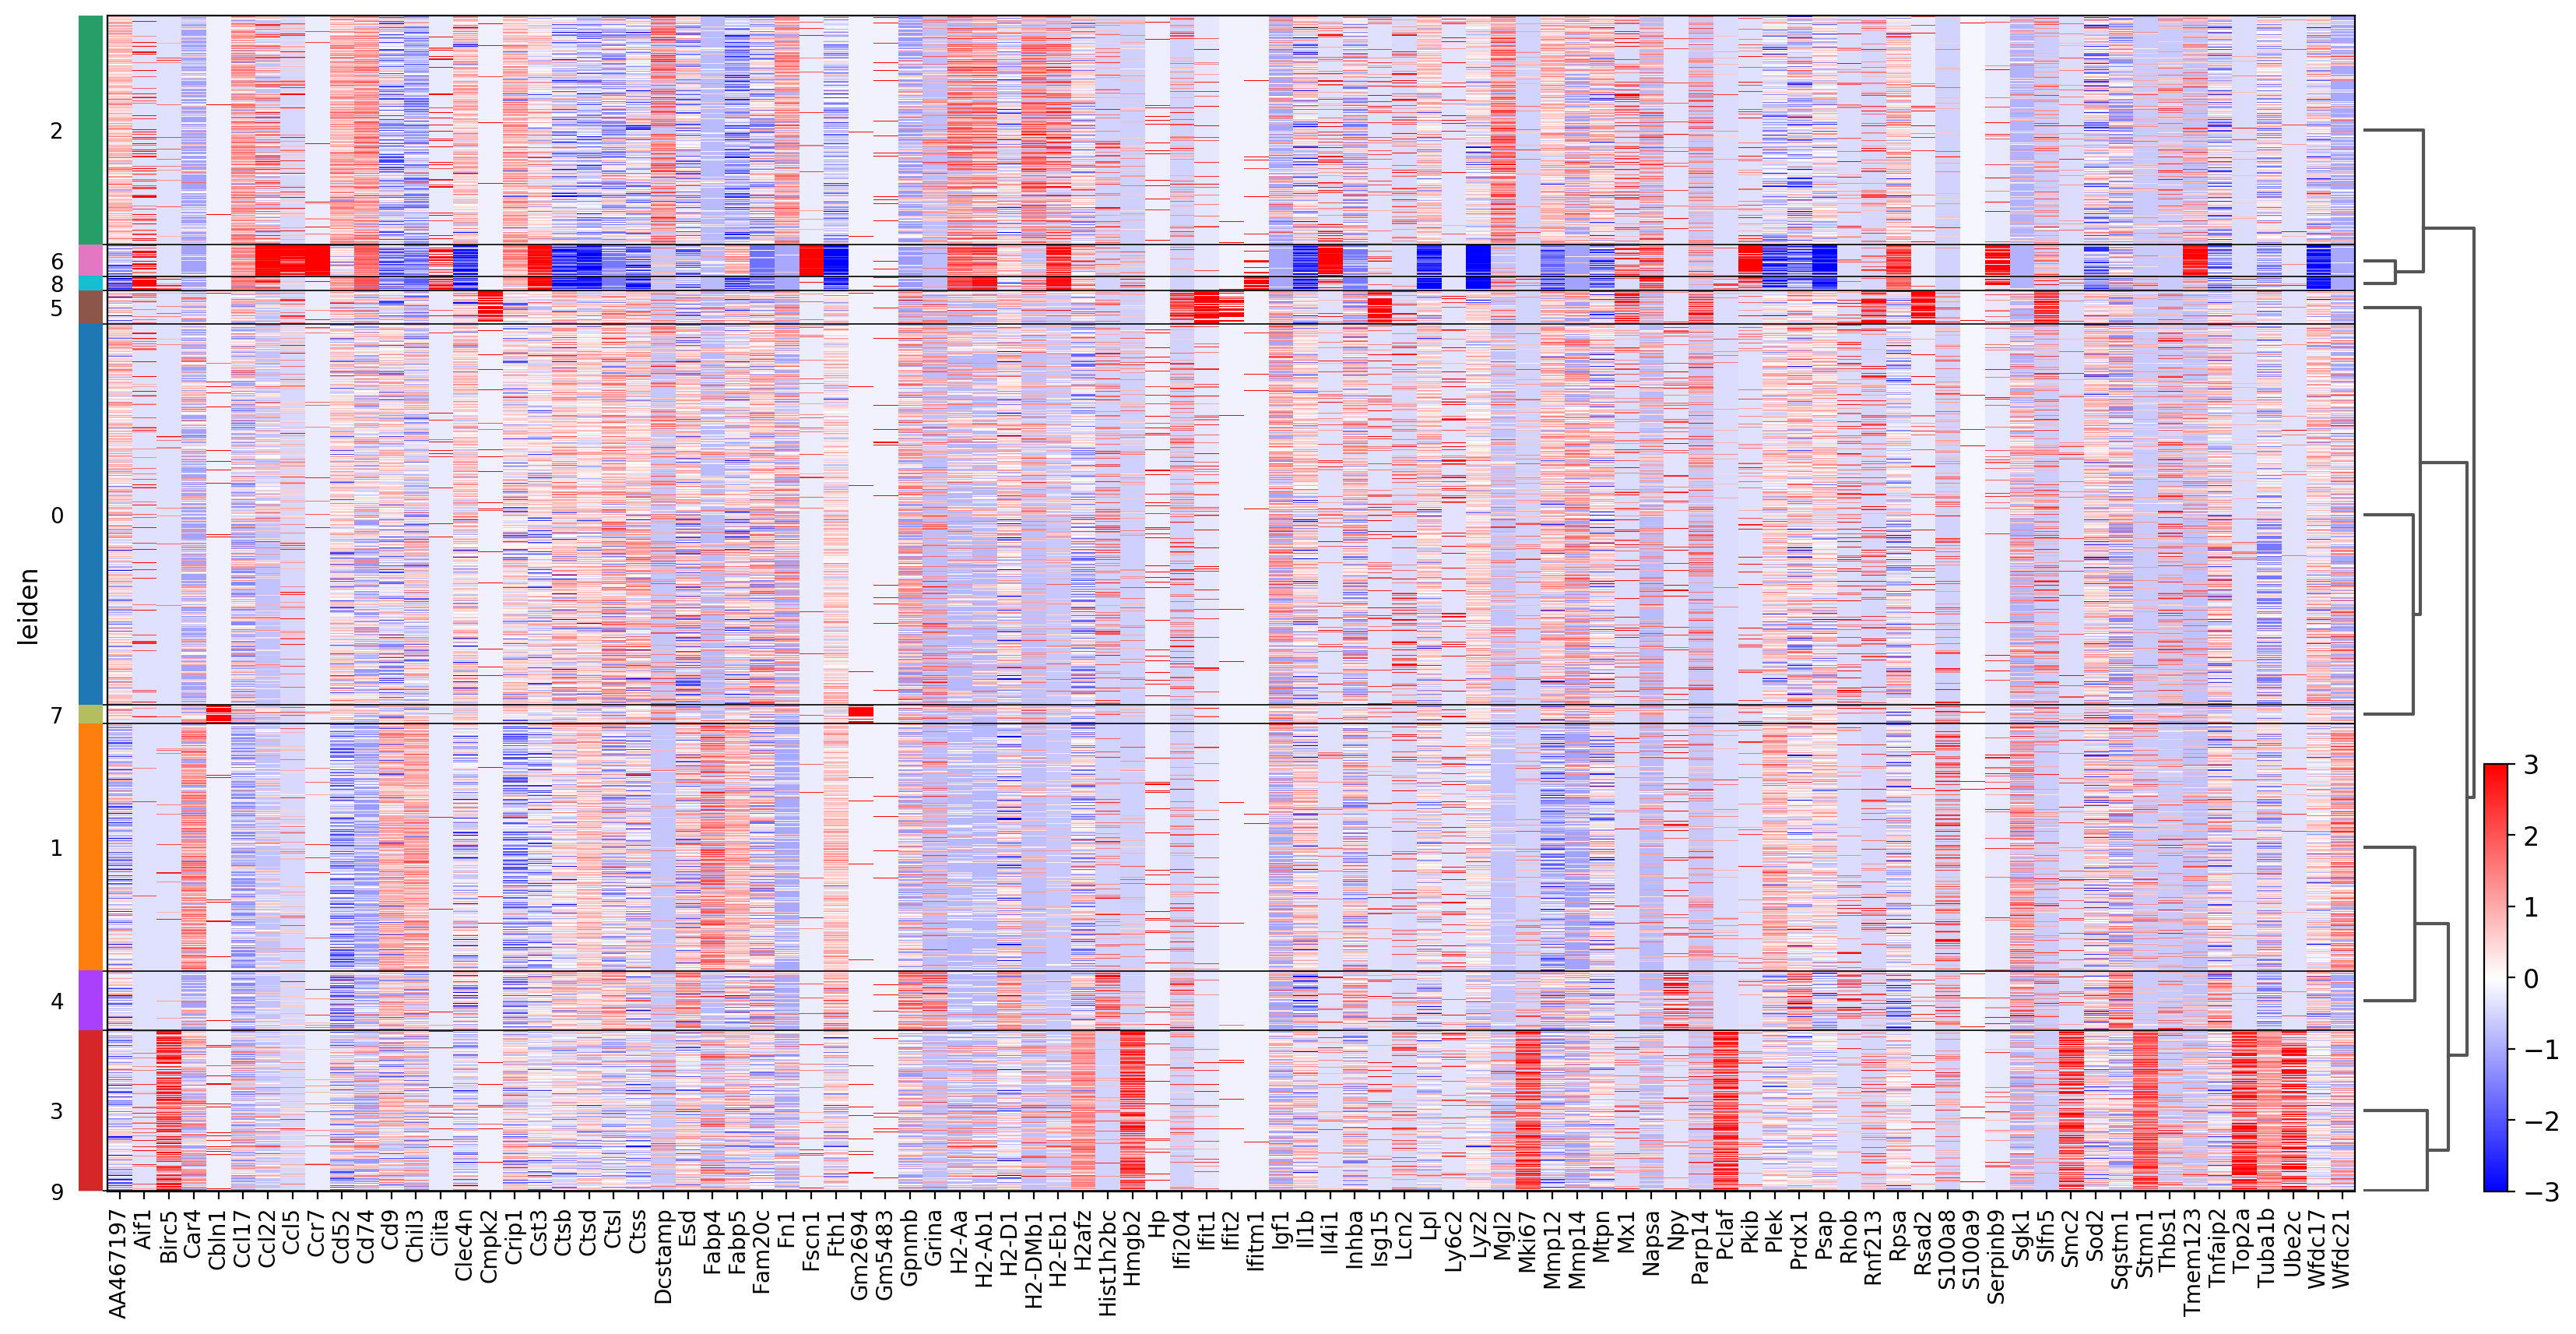

In [26]:
sc.pl.heatmap(adata, markerGenes, groupby='leiden', figsize=(20, 10),
              use_raw=False, vmin=-3, vmax=3, cmap='bwr', show_gene_labels=True, dendrogram=True, swap_axes=False)

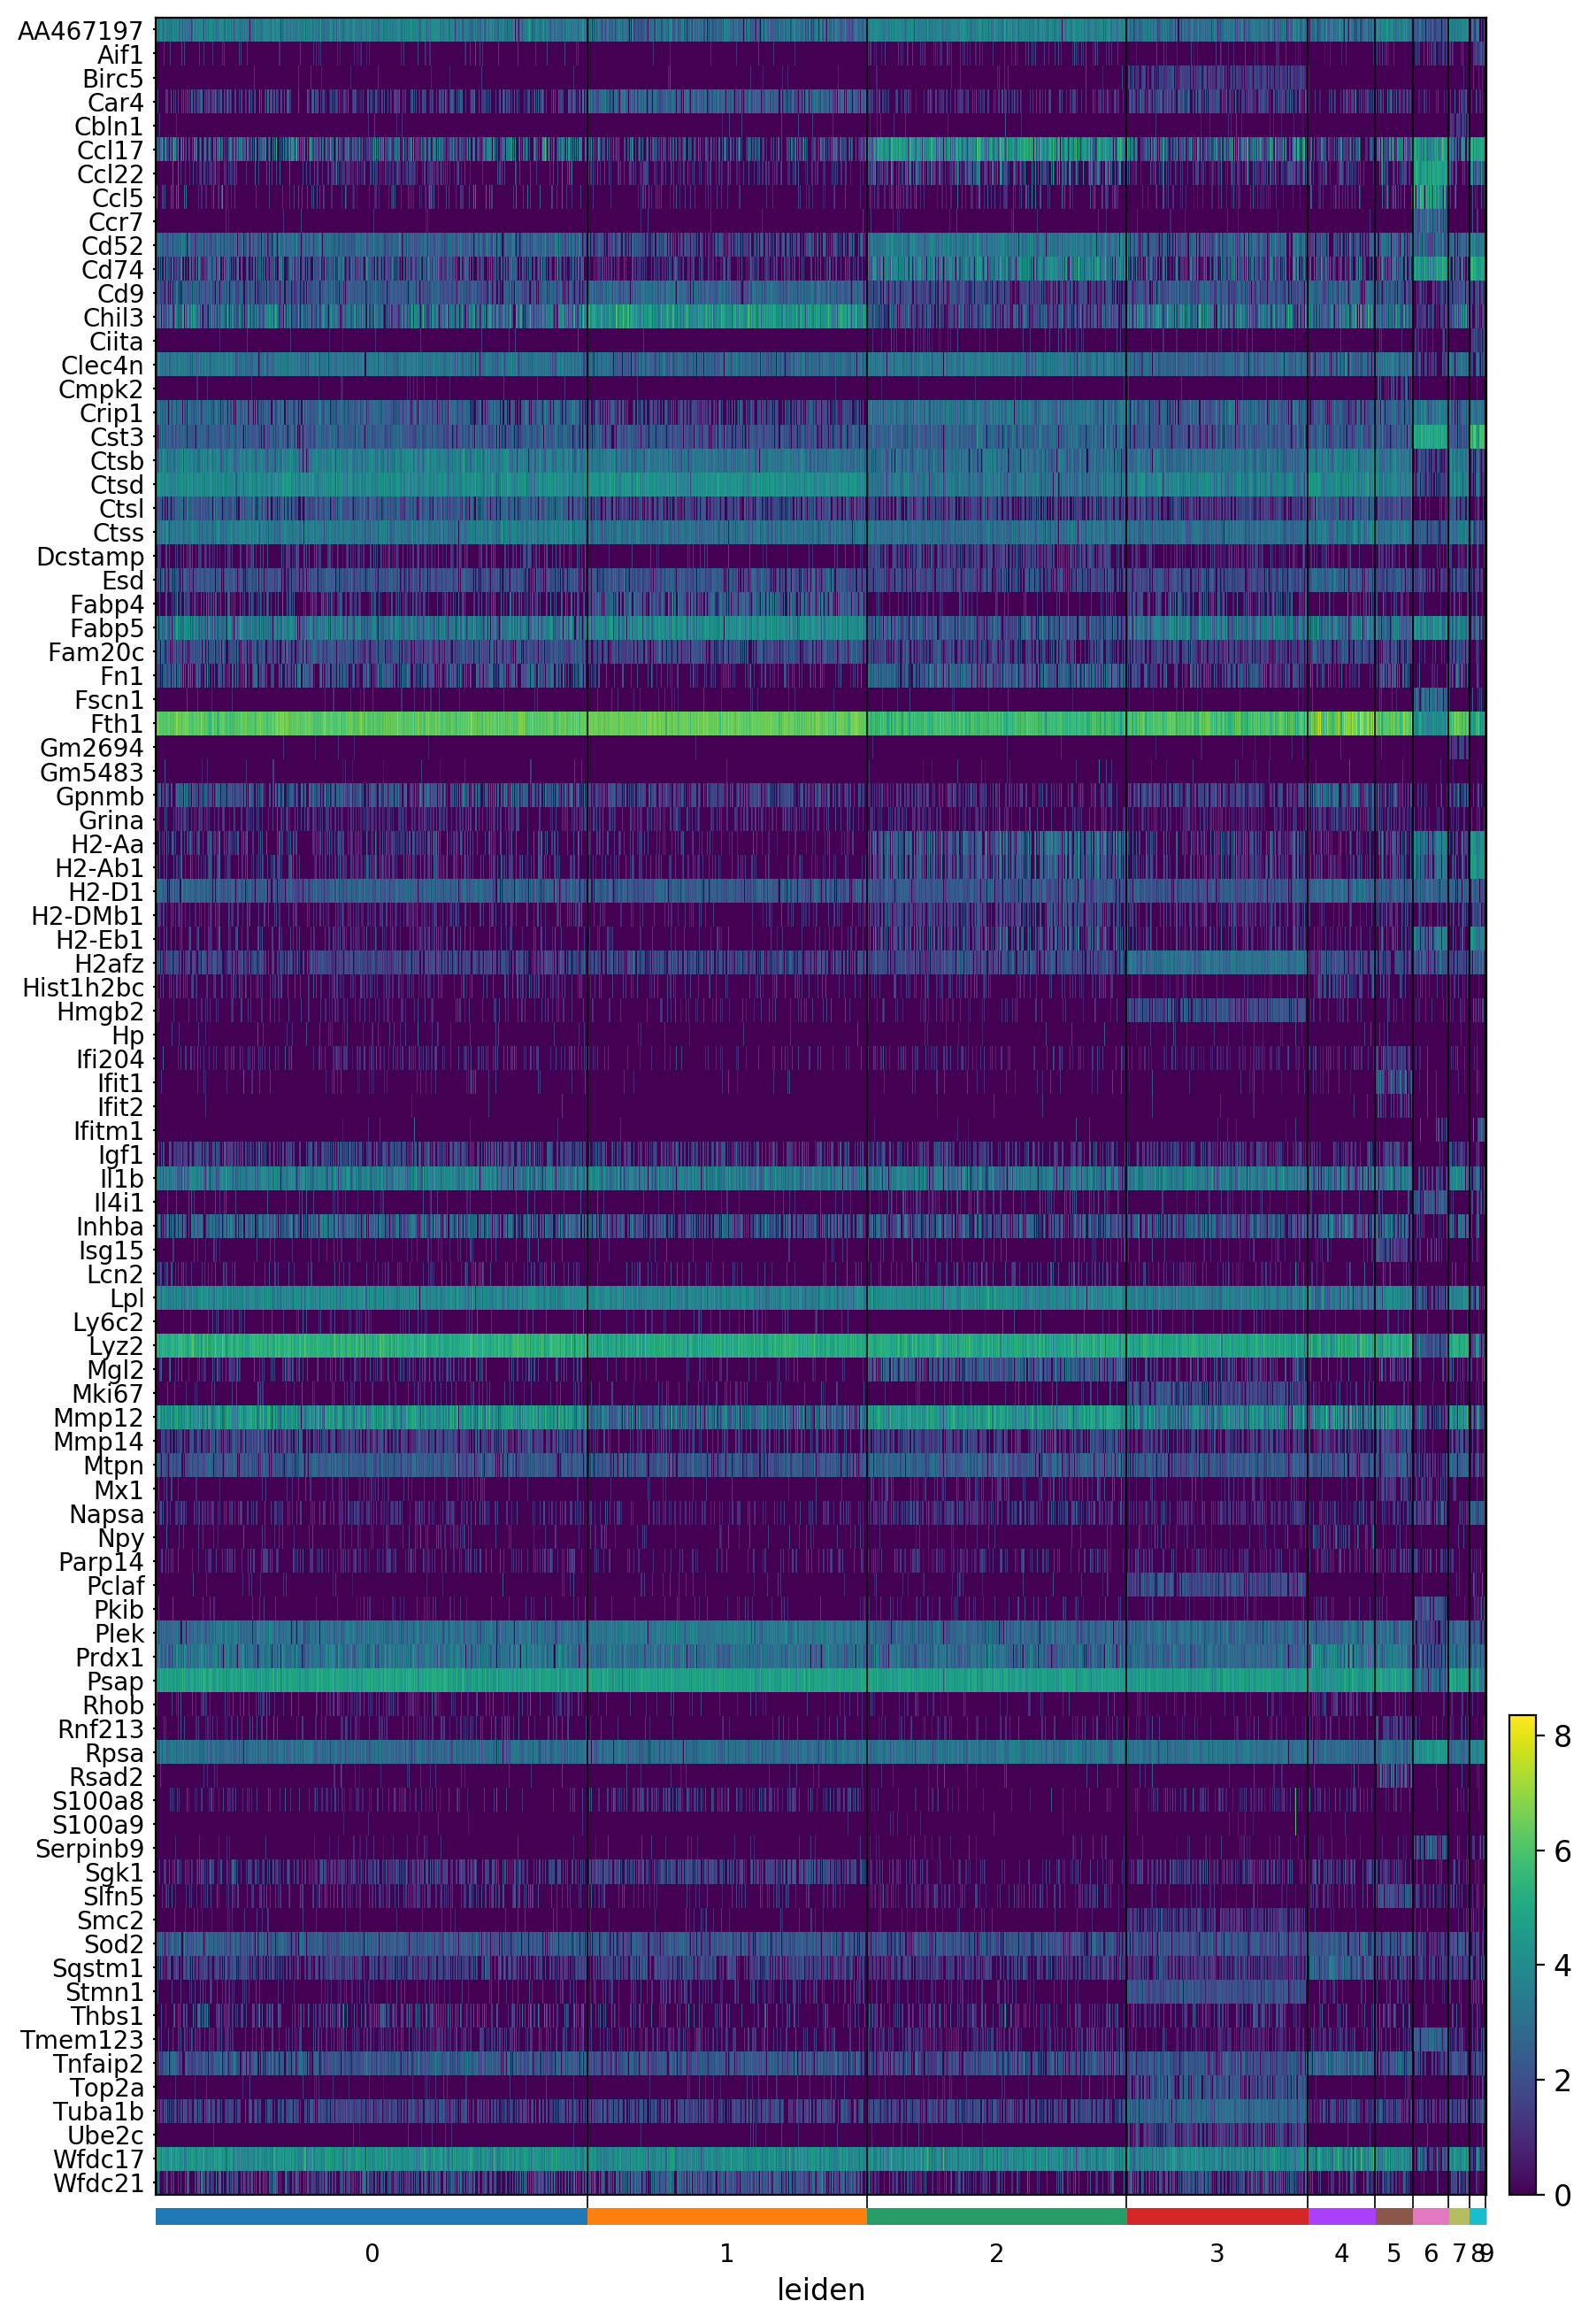

In [27]:
sc.pl.heatmap(adata,markerGenes, groupby='leiden', show_gene_labels=True, swap_axes=True)


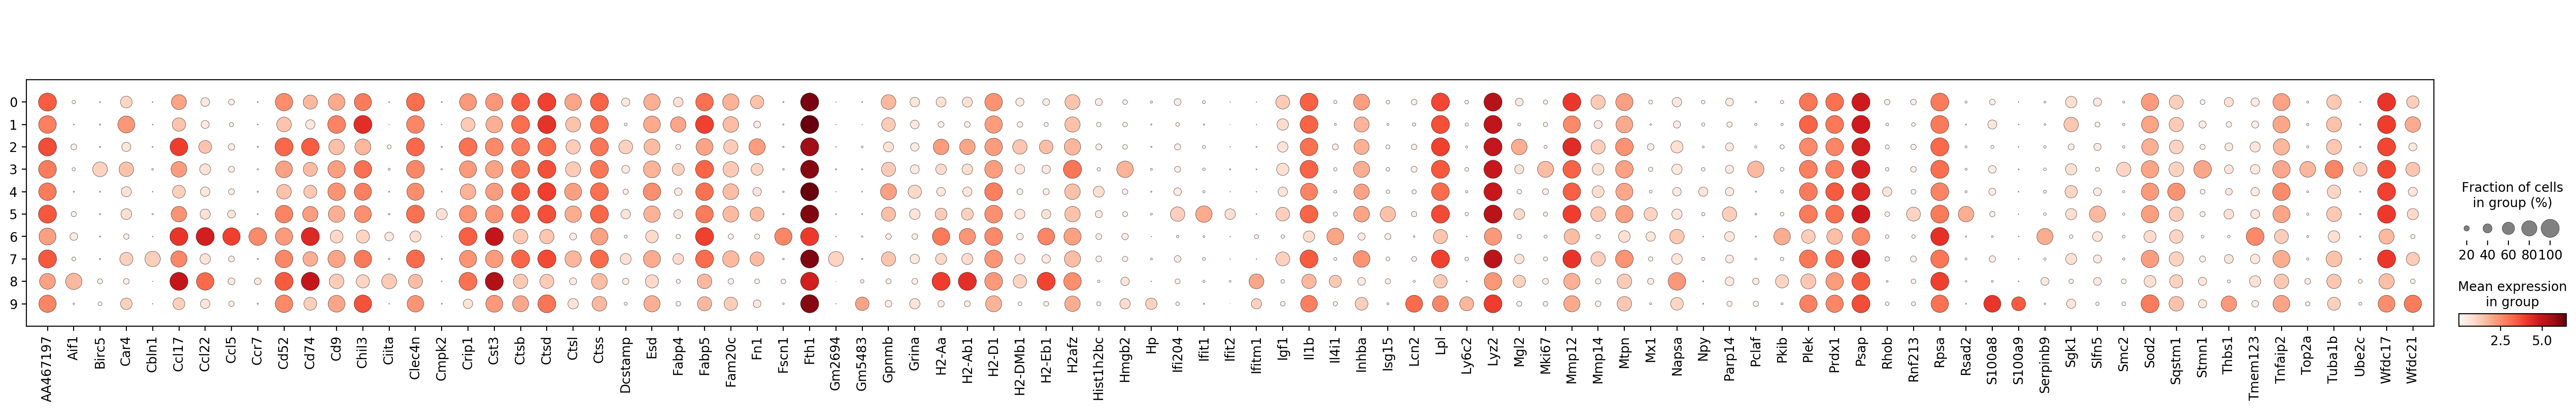

In [28]:
sc.pl.dotplot(adata, markerGenes, groupby='leiden')

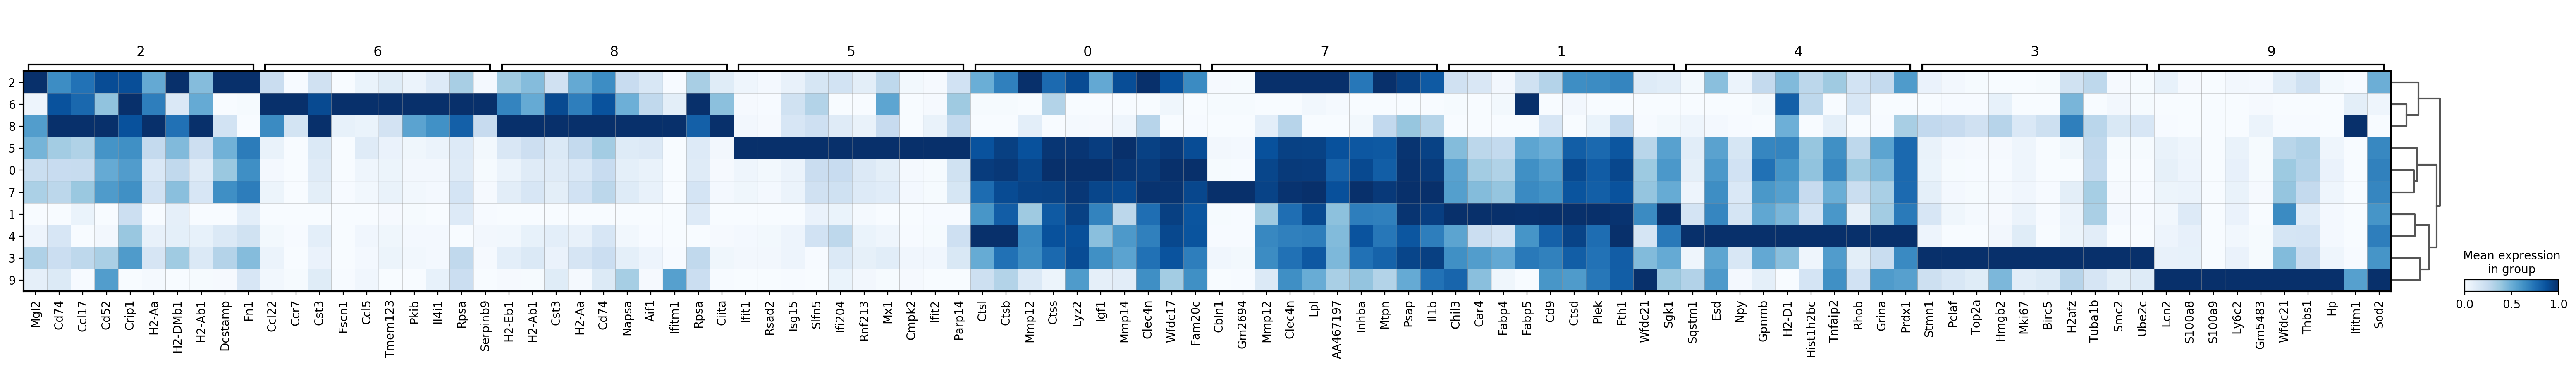

In [29]:
sc.pl.rank_genes_groups_matrixplot(adata, n_genes=10, standard_scale='var', cmap='Blues')

In [30]:
gene_list_url = 'https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt'

cell_cycle_genes = [str(x.strip(), 'utf-8').capitalize() for x in urlopen(gene_list_url)] # capitalize = shame


s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]


sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    643 total control genes are used. (0:00:14)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    683 total control genes are used. (0:00:15)
-->     'phase', cell cycle phase (adata.obs)


In [31]:
adata.obs.columns

Index(['barcode_rank', 'channel', 'empty_drops_FDR', 'log10_n_genes',
       'log10_n_umis', 'mt_frac', 'n_counts', 'n_genes', 'n_umis',
       'neg_log10_empty_drops_FDR',
       ...
       'ONE_NONGENE_SITE_325', 'ONE_NONGENE_SITE_326', 'ONE_NONGENE_SITE_327',
       'ONE_NONGENE_SITE_328', 'ONE_NONGENE_SITE_329', 'ONE_NONGENE_SITE_330',
       'leiden', 'S_score', 'G2M_score', 'phase'],
      dtype='object', length=3739)

... storing 'phase' as categorical


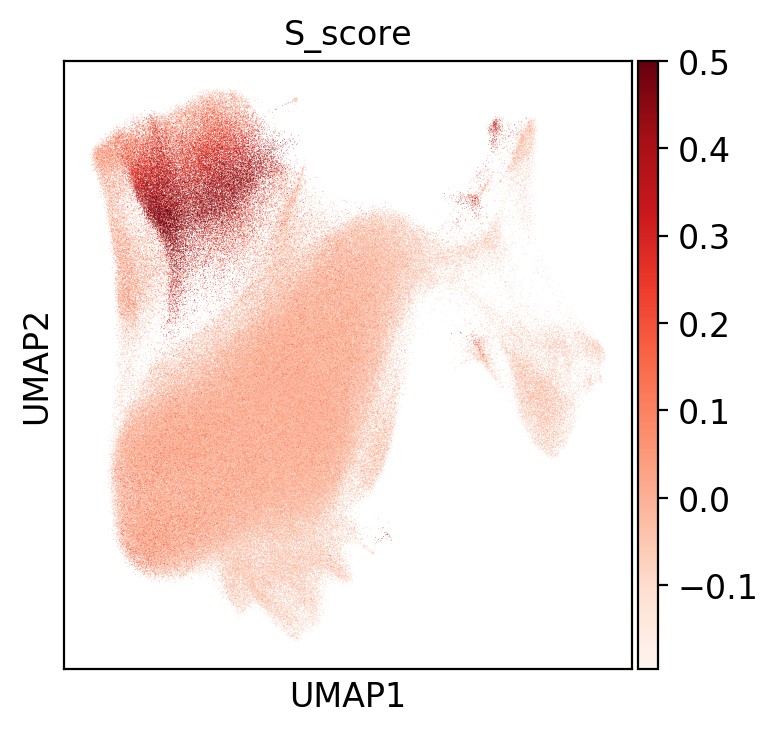

In [32]:
sc.pl.umap(adata, color='S_score', vmax=0.5, cmap='Reds')

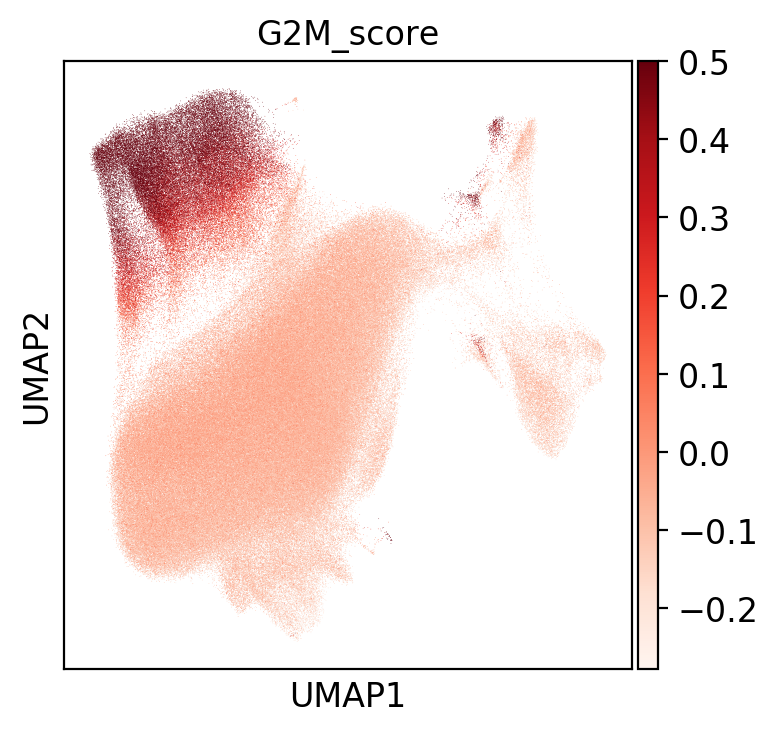

In [33]:
sc.pl.umap(adata, color='G2M_score', vmax=0.5, cmap='Reds')

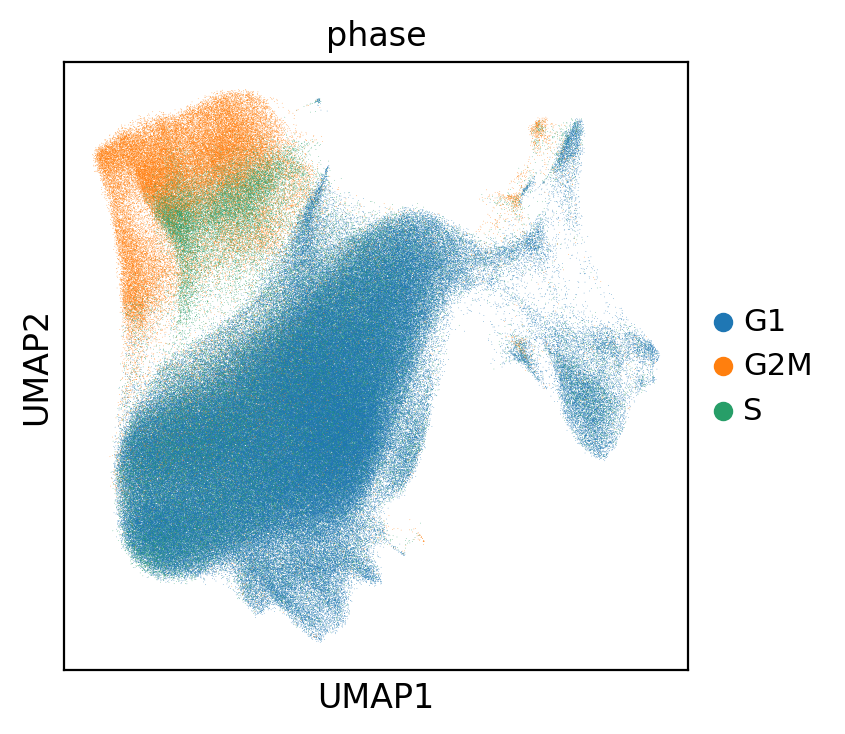

In [34]:
sc.pl.umap(adata, color='phase', vmax=0.5, cmap='Reds')

In [35]:
adata.write("outputs/anndata/adata-hash-features_singlets_05242020.h5ad")

## Percent mito UMI

In [ ]:
f, ax = plt.subplots(1, 4, figsize=(20, 4))
sc.pl.scatter(adata,
              x='n_umis',
              y='n_genes',
              color='mt_frac',
              ax=ax[0],
              show=False,
              right_margin=2.85,
              title='Percent mitochondrial UMIs')
ax[0].set_xscale('log')
ax[0].set_yscale('log')

sc.pl.scatter(adata, x='n_umis', y='mt_frac', ax=ax[1], show=False)
ax[1].set_xscale('log')
plt.subplots_adjust(wspace=0.5)

sc.pl.violin(adata, keys='log10_n_umis', groupby='sample_name', rotation=90, ax=ax[2], show=False)
sc.pl.violin(adata, keys='log10_n_umis', groupby='sample_name', rotation=90, ax=ax[3], show=False)